In [2]:
import numpy as np
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
from sklearn import svm
from sklearn.utils.validation import check_is_fitted

In [63]:
nor_obs = np.load('train_mfcc20.npy') # 정상데이터 load

ano_obs = np.load('test_mfcc20.npy') # 불량데이터 load


nor_obs = pd.DataFrame(nor_obs.real)  # 데이터프레임화 .real 을 붙인 이유는 저 값을 보면 마지막에 +0.j 라는게 붙어있어서 .real로 떼어준다.
ano_obs = pd.DataFrame(ano_obs.real)  # 데이터프레임화

nor_obs= nor_obs.rename(columns={20: 'Category'})  # label 을 붙인 컬럼명을 Category 라고 지어준다
ano_obs = ano_obs.rename(columns={20: 'Category'})


train_feature = nor_obs.sample(n=2553)  # sample 함수를 사용해 정상 데이터들중 2553개를 랜덤으로 뽑아서 학습데이터로 저장해준다

train_feature = train_feature.drop('Category',1) # 학습데이터의 label을 떼어준다
train_rest = nor_obs.loc[~nor_obs.index.isin(train_feature.index)]  # 2553개의 학습데이터가 떼어진 나머지 309개를 train_rest로 저장
train_test = train_rest.sample(n=9)  # 309개의 train_rest 에서 9개를 랜덤으로 추출하여 test로 저장
train_valid = train_rest.loc[~train_rest.index.isin(train_test.index)]  # 나머지 300개를 valid로 저장

Y_1 = train_valid['Category']  # valid의 카테고리를 Y_1 으로 저장

X_test_1 = train_valid.drop('Category',1)  # valid의 카테고리를 제거 후 X_test_1 에 저장

oneclass = svm.OneClassSVM(kernel = 'rbf',gamma=0.01, nu=0.0121)  # ocsvm 모델 정의

oneclass.fit(train_feature)  # 학습데이터를 가지고 ocsvm모델에 fitting

fraud_pred = oneclass.predict(X_test_1)  # fitting된 ocsvm 모델에 valid 데이터를 평가함

#unique, counts = np.unique(fraud_pred, return_counts = True)
#print(unique, counts)
Y_1 = Y_1.to_frame()  # Y_1 의 컬럼명 제거
Y_1 = Y_1.reset_index()  # Y_1의 인덱스도 제거
fraud_pred = pd.DataFrame(fraud_pred)  # valid데이터를 평가한것을 데이터프레임화
fraud_pred = fraud_pred.rename(columns={0:'prediction'})  # 이 데이터프레임의 컬럼명을 prediction 으로 바꿔줌

TP=FN=FP=TN=0
for j in range(len(Y_1)):  # valid 데이터를 평가한것의 길이 만큼 반복수행(여기서는 그럼 300번 반복수행됨)
    if Y_1['Category'][j]==0 and fraud_pred['prediction'][j]==1:  # 원래 valid의 카테고리가 0이고(정상) 평가한 prediction이 1일때 TP로 저장(ocsvm은 평가했을때 정상일때 1로 비정상일때 -1로 평가된다.)
        TP=TP+1
    elif Y_1['Category'][j]==0 and fraud_pred['prediction'][j] == -1:
        FN=FN+1
    elif Y_1['Category'][j]==1 and fraud_pred['prediction'][j]==1:
        FP=FP+1
    else:
        TN=TN+1
print(TP, FN, FP, TN)

300 0 0 0


In [67]:
X_test_1 = train_test.drop('Category',1)  # 정상 test데이터에서 카테고리를 제거한 값을 X_test_1 에 저장

X_test_2 = ano_obs.drop('Category',1)  # 비정상 데이터의 카테고리를 제거한 값을 X_test_2 에 저장
X_test = X_test_1.append(X_test_2) # 두개를 합쳐서 X_test에 저장
Y_1 = train_test['Category'] # 정상 test데이터의 카테고리를 Y_1 에 저장

Y_2 = ano_obs['Category']  # 비정상 데이터의 카테고리를 Y_2 에 저장
Y_test = Y_1.append(Y_2) # 두개를 합쳐서 Y_test에 저장
fraud_pred = oneclass.predict(X_test)  # X_test를 현재 fitting된 ocsvm 모델에 넣어 평가
print(oneclass.score_samples(X_test))  # X_test를 ocsvm에 넣었을때의 raw score를 본다.
#unique, counts = np.unique(fraud_pred, return_counts = True)
Y_test = Y_test.to_frame()  # Y_test의 컬럼명 제거
Y_test = Y_test.reset_index() # Y_test의 인덱스 제거
fraud_pred = pd.DataFrame(fraud_pred) # test데이터의 평가된 값을 데이터프레임화 하며 fraud_pred에 저장
fraud_pred = fraud_pred.rename(columns={0:'prediction'}) # fraud_pred의 컬럼명을 prediction 으로 바꿈
TP=FN=FP=TN=0
for j in range(len(Y_test)):
    if Y_test['Category'][j]==0 and fraud_pred['prediction'][j]==1:
        TP=TP+1
    elif Y_test['Category'][j]==0 and fraud_pred['prediction'][j] == -1:
        FN=FN+1
    elif Y_test['Category'][j]==1 and fraud_pred['prediction'][j]==1:
        FP=FP+1
    else:
        TN=TN+1
print(TP, FN, FP, TN)

[8.17184877 8.5671166  7.31909231 7.66633338 8.22948074 8.44998546
 8.43985709 7.32438765 8.13891729 6.62137236 4.8717926  3.00596677
 5.0570885  0.05141262 0.44283501 0.04773139 5.43470827 0.45229177]
9 0 0 9


In [77]:
oneclass.score_samples(X_test)[0:9]  # 정상test데이터 9개의 raw score 값을 확인해본다

array([8.17184877, 8.5671166 , 7.31909231, 7.66633338, 8.22948074,
       8.44998546, 8.43985709, 7.32438765, 8.13891729])

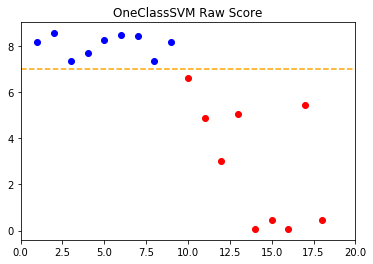

In [79]:
x=[1,2,3,4,5,6,7,8,9]
x1=[10,11,12,13,14,15,16,17,18]
plt.scatter(x,oneclass.score_samples(X_test)[0:9],c='b') # 정상 test 데이터 9개의 raw score 값을 파란색으로
plt.scatter(x1,oneclass.score_samples(X_test)[9:18],c='r') # 비정상 test 데이터 9개의 raw score 값을 빨간색으로 스캐터플랏을 찍어본다
plt.title("OneClassSVM Raw Score")
plt.axhline(y=7,color='orange',ls="--")  # 7 이라는 숫자는 이렇게 여러번 실행 해본 결과 정상 score값은 7을 항상 넘고 비정상 score값은 7을 항상 못넘길래 7로 지정하여서 줄을 그었다.
plt.xlim([0,20])
plt.show()

In [45]:
accuracy = (TP+TN)/(TP+FN+FP+TN)
print (accuracy)
sensitivity = TP/(TP+FN)
print (sensitivity)
specificity = TN/(TN+FP)
print (specificity)

1.0
1.0
1.0
